# Pima Indians Diabetes Database

# Projet Diabète
Ensemble de données est à l'origine de l'Institut national du diabète et des maladies digestives et rénales.  
  
Tous les patients ici sont des femmes d'au moins 21 ans d'origine indienne Pima.  
  
9 colonnes:
- 8 variables prédictives qui résument des données médicales
    - Grossesses : Nombre de fois enceintes
    - Glucose : Concentration de glucose plasmatique sur 2 heures dans un test oral de                    tolérance au glucose
    - Pression artérielle: Pression artérielle diastolique (mm Hg)
    - SkinThickness: Triceps épaisseur de pliage de peau (mm)
    - Insuline : insuline sérique de 2 heures (mu U/ml)
    - IMC : Indice de masse corporelle (poids en kg/(hauteur en m)2)
    - DiabetesPedigreeFunction: Diabetes pedigree function (une fonction qui marque 
      la probabilité de diabète en fonction des antécédents familiaux)
    - Âge : Âge (années)
    - Résultat : Variable de classe (0 si non diabétique, 1 si diabétique)

- 1 target : 
  - Outcome : Si le patient est diabétique ou non ( 0 = Clean, 1 = Diabétique )

## Import librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# XG Boost
import xgboost as xgb
# MSNO (graphique visualiser les valeurs manquantes)
import missingno as msno

# Train, Test & Split
from sklearn.model_selection import train_test_split
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
# Accuracy
from sklearn.metrics import accuracy_score
# Decision Tree
from sklearn import tree
from sklearn.tree import *
from sklearn.tree import DecisionTreeClassifier
# Ada Boost
from sklearn.ensemble import AdaBoostClassifier
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
# Métrique d’évaluation ( qui quantifie la performance d’un modèle prédictif )
from imblearn.metrics import classification_report_imbalanced
# XG Boost
from xgboost import XGBClassifier
# Classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
# KNNImputer
from sklearn.impute import KNNImputer
from sklearn import neighbors
# Dendogram
from scipy.cluster.hierarchy import dendrogram, linkage
# Import fichier functions créée dans le dossier anaconda3/lib
import functions

# SMOTE
from imblearn.over_sampling import SMOTE

# Permet de conserver et de travailler sur les mêmes résultat, si je transmet mon code à un collègue 
import random
random.seed(5)

# Configure la bibliothèque que l'on va utiliser pour dessiner le graphique. Elle est souvent utilisée avec l'argument "inline", qui indique que l'on va utiliser la bibliothèque intégrée à Notebook
%matplotlib inline

## Import de la BDD

In [2]:
data = pd.read_csv("csv/diabetes.csv")

In [3]:
# Voir le total de nos lignes et le total de nos colonnes
data.shape

(768, 9)

In [4]:
# Voir les 5 première lignes de notre jeu de données
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [5]:
# Regarder si on a la moindre valeur null sur tout le jeu de données
# data.isnull()
# Permet de voir le nombre de nan contenu dans notre dataset
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
# Compter les cellules avec 0 Valeurs pour chaque variable et publier les comptes ci-dessous
(data.Pregnancies == 0).sum(),(data.Glucose==0).sum(),(data.BloodPressure==0).sum(),(data.SkinThickness==0).sum(),(data.Insulin==0).sum(),(data.BMI==0).sum(),(data.DiabetesPedigreeFunction==0).sum(),(data.Age==0).sum()

(111, 5, 35, 227, 374, 11, 0, 0)

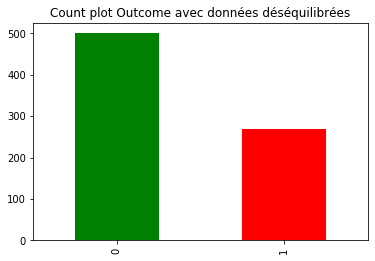

In [74]:
# Répartition des données, non diabétique(0) ou diabétique(1), sur un histogramme
data2['Outcome'].value_counts().plot(kind='bar', title='Count plot Outcome avec données déséquilibrées', color = ['Green', 'Red'])

In [16]:
# On fait une copie de notre Dataframe
data2 = data.copy()

## Nettoyage des données 

Pour nettoyer ce jeu de données nous avons décidés de supprimer les valeurs 0, donc de faire un DROP. On va d'abord transformer les 0 en nan, puis les supprimer.

Une deuxiéme méthode était d'imputer les données en faisant un FILLNA, donc en remplaçant les données par mean, median et KNN.

In [17]:
# Transformer les 0 en nan sur les colonnes :
# BMI, BloodPressure, Glucose, SkinThickness 
data2["Glucose"].replace(to_replace = 0, value = np.nan, inplace = True)
data2["BloodPressure"].replace(to_replace = 0, value = np.nan, inplace = True)
data2["SkinThickness"].replace(to_replace = 0, value = np.nan, inplace = True)
data2["BMI"].replace(to_replace = 0, value = np.nan, inplace = True)
data2["Insulin"].replace(to_replace = 0, value = np.nan, inplace = True)

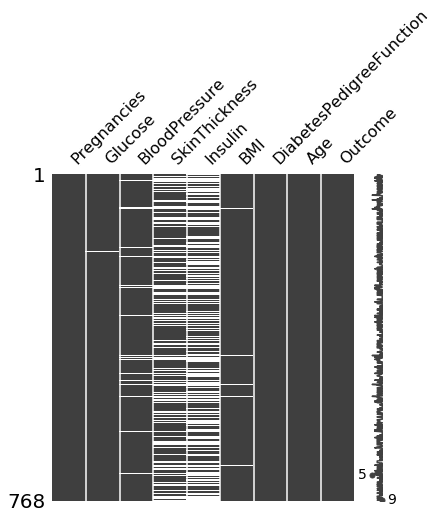

In [18]:
# On visualise si l'on a des données manquantes par un graphique
msno.matrix(data2, figsize = (6, 6))

In [19]:
# On vérifie le résultat de la commande précédente (True = valeurs tranformées en Nan)
print(data2.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [20]:
# On supprime les valeurs nan avec la function dropna :
# Fonction utilisée pour supprimer les lignes et les colonnes avec des valeurs Null/NzN/Nat
# Paramètres :
# axis : 0 = ligne, 1 = colonne
# how : prend la valeur de chaîne de deux sortes seulement (' n’importe quel' ou 'all'). 'any' baisse la ligne/colonne si n’importe quelle valeur est Null et 'all' ne baisse que si les valeurs ALL sont nulles.
dataclean = data2.dropna(axis=0, how='any')

In [60]:
# J'enregistre ma BDD drop dans mon dossier csv
dataclean.to_csv("csv/datadrop.csv")

### Visualisation des données

### Corrélations :

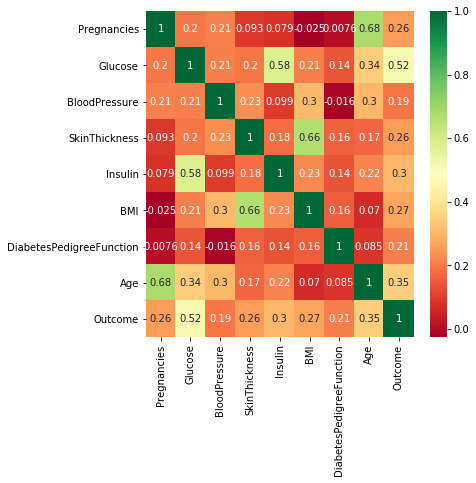

In [21]:
# Obtenir des corrélations de chaque fonctionnalités dans le jeu de données
plt.figure(figsize=(6,6))
# Plot heat map
g=sns.heatmap(dataclean.corr(),annot=True,cmap="RdYlGn")

In [22]:
# On regarde le nombre de personnes qui ont le diabéte, sachant que :
# Target = Outcome :
# 0 = Pas de diabéte = False
# 1 = Diabétique  = True
diabetes_true_count = len(dataclean.loc[dataclean['Outcome'] == False])
diabetes_false_count = len(dataclean.loc[dataclean['Outcome'] == True])

(diabetes_true_count,diabetes_false_count)

(262, 130)

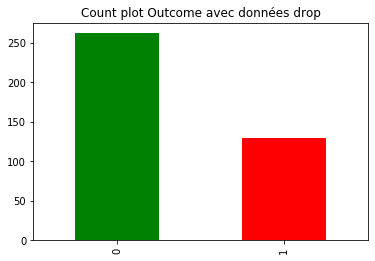

In [75]:
# Répartition des données, non diabétique(0) ou diabétique(1), sur un histogramme
dataclean['Outcome'].value_counts().plot(kind='bar', title='Count plot Outcome avec données drop', color = ['Green', 'Red'])

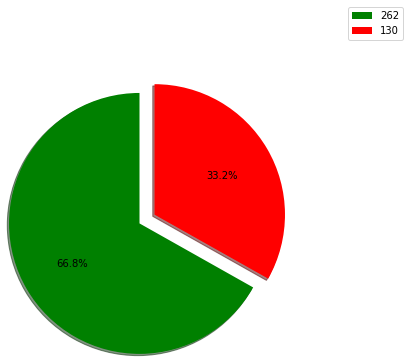

In [24]:
# Répartition des données, non diabétique(0) ou diabétique(1), en pourcentage sur un camenbert
plt.pie(x=dataclean['Outcome'].value_counts(), explode=(0.1,0.1), autopct="%1.1f%%", shadow=True,
        startangle=90, radius=1.5, colors = ['Green', 'Red'])
plt.legend(labels=dataclean['Outcome'].value_counts(), bbox_to_anchor=(1.7, 1.5))
plt.show()

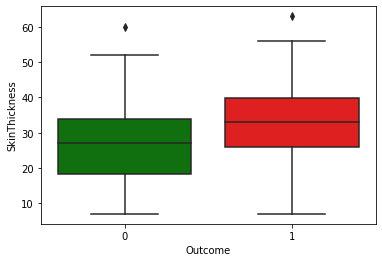

In [25]:
# Classification de la colonne DiabetesPedigreeFunction en fonction de la classe 'Pregnancies', sur une boîte à moustache
sns.boxplot(x="Outcome", y="SkinThickness", data=dataclean, palette = ('Green', 'Red'))

La mediane est situé à 38 pour les non diabétiques, et à 31 pour les diabétiques. Une densité de population équilibrée pour les diabétiques. On constate des outliers. Les données sont rapprochés et quasi égal entre le 1er et 3éme quartil pour les diabétiques.

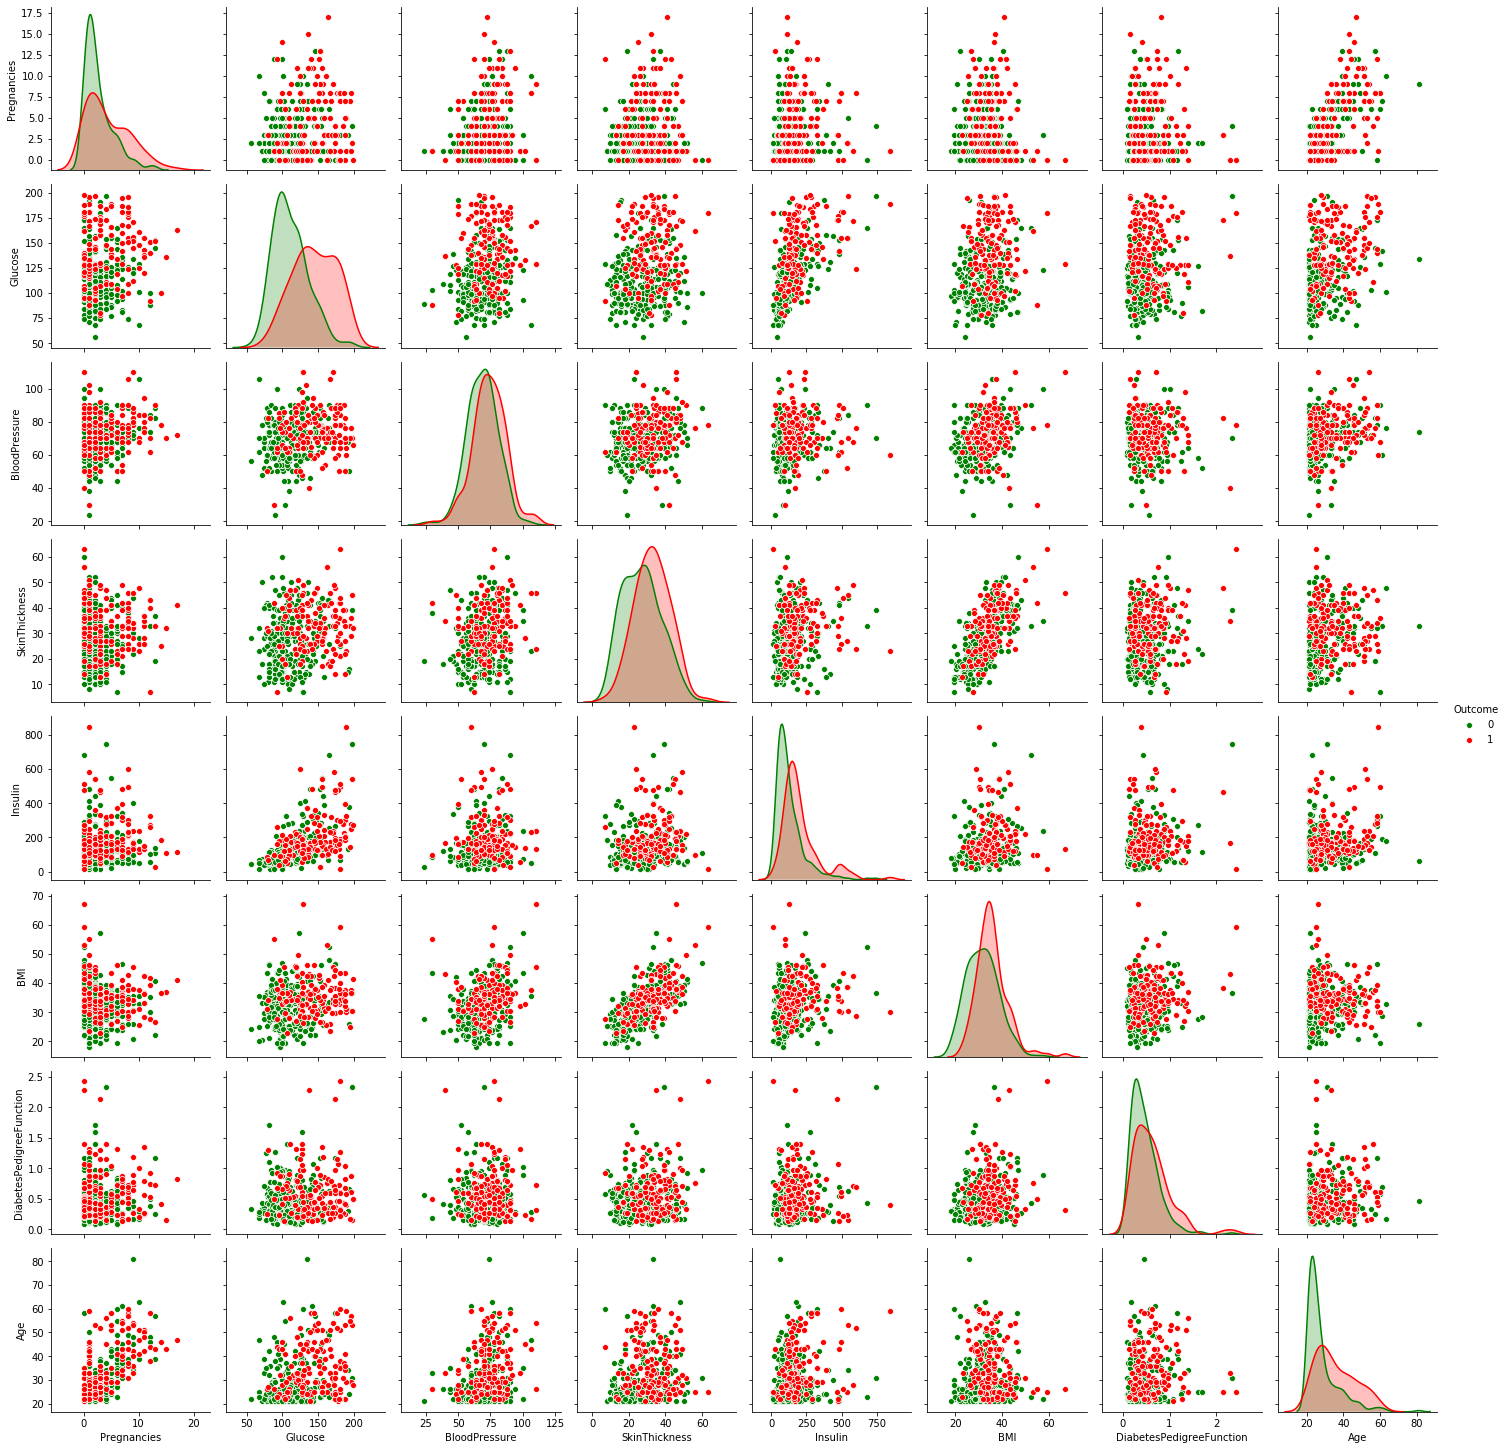

In [26]:
# On visualise nos différentes corrélation possible
sns.pairplot(dataclean, hue = 'Outcome', palette = ('Green', 'Red'))

On peut voir que nous avons des corrélations entre Glucose et Insulin, SkinThickness et BMI. Et d'autres pas franchement flagrante.

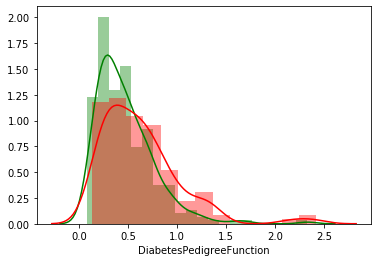

In [38]:
sns.distplot(dataclean['DiabetesPedigreeFunction'].loc[dataclean['Outcome'] == 0], color = 'Green')
sns.distplot(dataclean['DiabetesPedigreeFunction'].loc[dataclean['Outcome'] == 1], color = 'Red')

Displot = distribution plot, avec un filtre sur l'Outcome (diabétuqe / non diabétique). Distribution de la population, la totalité du graphique représente 100%. Plus on a le DiabetesPedigreeFunction qui est élevée, plus on a de personnes diabétique.

### SMOTE ( Synthetic Minority Over-sampling Technique )

In [39]:
# J’ai utilisé le smote pour augmenter la classe minoritaire.
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(dataclean[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']], dataclean['Outcome'])
y_smote.value_counts()


1    262
0    262
Name: Outcome, dtype: int64

### PCA ( Principal Component Analysis ) ACP ( L’analyse en composantes principales )

Mathématiquement cela consiste à transformer des variables liées entre elles (dites « corrélées ») en nouvelles variables décorrélées les unes des autres.

Ces nouvelles variables sont nommées « composantes principales », ou axes principaux.

Cela permet notamment de réduire le nombre de variables et de rendre l’information plus lisible si l’on a un jeu de données important avec de nombreuses variables.

l’ACP ou PCA peut servir aussi à la vérification d’un jeu de données en identifiant les valeurs aberrantes ou d’étape préalable à d’autres traitements statistiques.

In [40]:
# On stocke la function PCA dans une variable
pca = PCA()
# On sélectionne toute les colonnes de notre dataset excepté la target = 'Outcome'
PcaSmote = X_smote.iloc[:, :8]

In [41]:
# Mettre à l'échelle = normaliser :
ScalePca = pd.DataFrame(scale(PcaSmote), columns = PcaSmote.columns)

In [42]:
# On fit = entraîne notre nouveau jeux de données et transform = créer les composantes principales :
ScaleTransform = pca.fit(ScalePca).transform(ScalePca)
X = pd.DataFrame(ScaleTransform)
X

0         1         2         3         4         5         6  \
0   -2.326280 -0.015899 -0.294060 -0.796704  0.160136  0.300593 -0.146747   
1    0.327087  2.539987  2.054705  4.792033  0.021272 -0.246000  0.813131   
2   -1.992966  0.164547 -0.310241  0.081217  1.772856  0.288613 -0.104475   
3    2.954825 -0.522704  2.207322 -1.675902  0.904123  0.358574 -1.090451   
4    2.843693 -1.399299  4.557629 -1.446528  0.435980  2.161983  0.441208   
..        ...       ...       ...       ...       ...       ...       ...   
519  1.669575  0.145687  2.496231 -1.564543  1.033600  0.606760 -0.137442   
520  2.166928 -1.539207  1.822122 -0.037971  0.936088  0.951817  0.394027   
521  1.649694  0.380831 -0.394750 -0.882000 -0.277859 -0.536289 -0.365368   
522  0.062323 -0.536400 -0.999317 -0.755330 -0.139709  0.840895  0.398777   
523  2.346176  0.260706 -0.311645 -1.087375  0.735678  0.925946  0.958739   

            7  
0   -0.027027  
1    0.476195  
2    0.061066  
3    1.561422  
4    1.702821  
..        ...  
519  0.433189  
520 -0.146934  
521 -0.508224  
522  0.752455  
523  0.348846  

[524 rows x 8 columns]

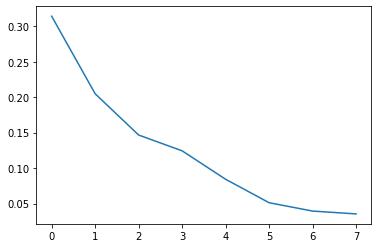

In [43]:
# On visualise explained_variance_ratio_ : c'est le pourcentage de variance expliquée
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [44]:
print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)

print("Composantes principales : ")
pd.DataFrame(pca.components_)

Pourcentage de variance expliquée : 
[0.31417328 0.20484112 0.14661595 0.12432933 0.08422583 0.05113322
 0.03935869 0.03532258]
Composantes principales : 


0         1         2         3         4         5         6  \
0  0.318036  0.435674  0.330422  0.376943  0.369071  0.350358  0.139270   
1 -0.525216 -0.050552 -0.030637  0.445176  0.029798  0.525888  0.200223   
2 -0.245609  0.459390 -0.484788 -0.230206  0.591641 -0.220505  0.180191   
3  0.196027 -0.169781 -0.286286  0.039824 -0.253102 -0.033347  0.867322   
4  0.305677 -0.202625 -0.715358  0.421991  0.047639  0.136726 -0.371607   
5 -0.012302 -0.722146  0.176545 -0.042150  0.654474 -0.038090  0.094287   
6  0.034672 -0.047421 -0.160733 -0.646216 -0.020245  0.724599 -0.051087   
7 -0.655331 -0.054475 -0.064529  0.087774 -0.133354 -0.075947 -0.078782   

          7  
0  0.423575  
1 -0.452700  
2 -0.097431  
3  0.178275  
4  0.128984  
5  0.082048  
6  0.158289  
7  0.725222

In [45]:
print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_.cumsum())

Pourcentage de variance expliquée : 
[0.31417328 0.5190144  0.66563035 0.78995968 0.87418551 0.92531873
 0.96467742 1.        ]


On constate que pour notre 1 ére variance on a 31%, notre seconde variance 52% et notre 3ème variance 66%.

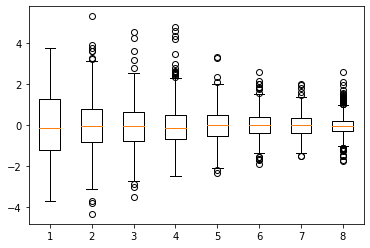

In [46]:
# Diagrammes boîte des composantes principales
plt.figure()
plt.boxplot(ScaleTransform[:, :8])
plt.show()

Notre boîte à moustache représente la répartition des données des componsantes principales. On a une densité de répartition assez homogéne.

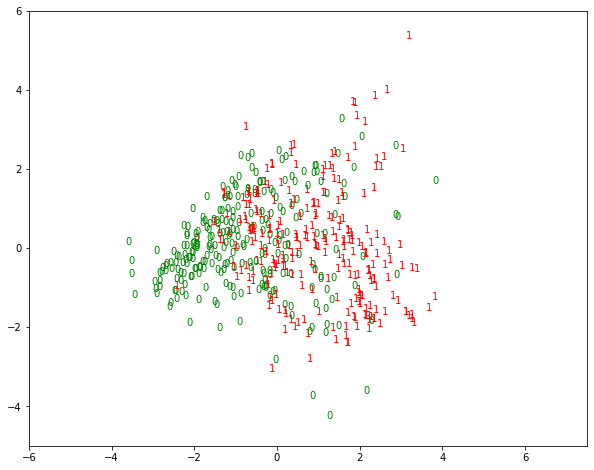

In [47]:
plt.figure(figsize=(10, 8))
for i, j, nom in zip(ScaleTransform[:,0], ScaleTransform[:,1], y_smote):
    color = "Red" if nom == 1 else "Green"
    plt.text(i, j, nom, color=color)
plt.axis((-6,7.5,-5,6))
plt.show()

Nous visualisons les diabétiques et non diabétiques sur nos deux composantes principales. Elles sont bien représentatives de notre target ( Outcome ).

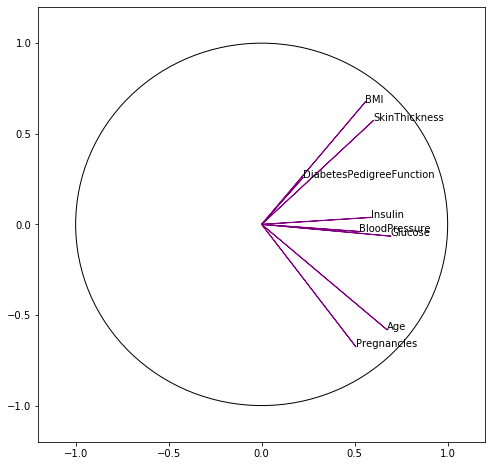

In [48]:
# Choisir le nombre de composante à prendre en compte pour notre visualisation avec explained_variance_[0 ou plus]
coord1 = pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, ScalePca.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='Purple')
plt.axis((-1.2,1.2,-1.2,1.2))
# Cercle
c = plt.Circle((0,0), radius=1, color='Black', fill=False)
ax.add_patch(c)
plt.show()

On peut voir que Blood Pressure et Glucose sont corrélées. 

Plus les lignes sont longues plus elles sont expliquées. Et plus elles sont rapprochées plus elles sont corrélées.

### Classification des variables

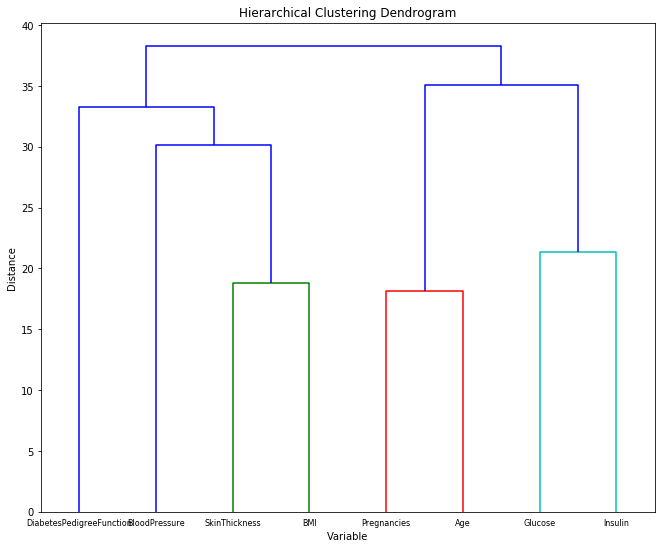

In [50]:
# Dendogram :
# Stratégie utilisée pour aider à l'interprétation du plan principal lorsque le nombre de variables est important
Z = linkage(ScalePca.T, 'ward')
plt.figure(figsize=(11, 9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variable')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8., labels=ScalePca.columns)
plt.show()

### Logistic Regression

In [51]:
X 
yLRSmote = y_smote

In [65]:
# On entraîne le dataframe en données d'entrainement et en données de test
# On entraîne le modèle sur 70% de données d'entrainement et 30% de données de test
X_train, X_test, y_train, y_test = train_test_split(X, yLRSmote, train_size=0.8, random_state=0)
# Création du modèle de régression logistique
model = LogisticRegression()
# Ajustement du modèle de régression logistique aux données
model.fit(X_train, y_train)
# Prédiction des classes sur les données de test
resultLR = model.predict(X_test)
# Evaluation des données prédites par rapport aux données réelles de test
print(classification_report_imbalanced(y_test, resultLR))
accuracy_score(y_test, resultLR)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.70      0.65      0.70      0.67      0.46        56
          1       0.65      0.65      0.70      0.65      0.67      0.45        49

avg / total       0.68      0.68      0.67      0.68      0.67      0.45       105



0.6761904761904762

In [66]:
# Matrice de confusion : tester les True et False, Positive et Negative :
print("Matrice de confusion (classes prédites vs réalité) :\n", confusion_matrix(y_test, resultLR))
# Evaluation des données prédites par rapport aux données réelles de test :
print("Accuracy score :\n", accuracy_score(y_test, resultLR))

Matrice de confusion (classes prédites vs réalité) :
 [[39 17]
 [17 32]]
Accuracy score :
 0.6761904761904762


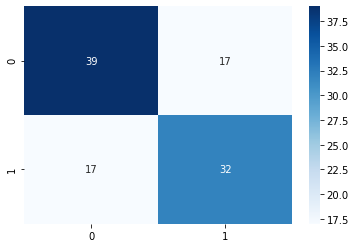

In [67]:
sns.heatmap(confusion_matrix(y_test, resultLR),annot=True,cmap="Blues")

### Random Forest

In [68]:
# Random Forest : classification
clf = RandomForestClassifier(n_jobs=2, random_state=0)
model = clf.fit(X_train, y_train)
resultRF = clf.predict(X_test)

# Matrice de confusion : tester les True et False, Positive et Negative :
# Une Confusion Matrix ou tableau de contingence est un outil permettant de mesurer les performances d’un modèle de Machine Learning en vérifiant notamment à quelle fréquence ses prédictions sont exactes par rapport à la réalité dans des problèmes de classification.
print("Matrice de confusion (classes prédites vs réelles) :\n", confusion_matrix(y_test, resultRF))
# Evaluation des données prédites par rapport aux données réelles de test :
print("Accuracy score :\n", accuracy_score(y_test, resultRF))

Matrice de confusion (classes prédites vs réelles) :
 [[40 16]
 [ 8 41]]
Accuracy score :
 0.7714285714285715


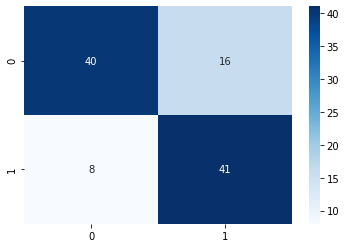

In [69]:
sns.heatmap(confusion_matrix(y_test, resultRF),annot=True,cmap="Blues")

### XG Boost

Matrice de confusion (classes prédites vs réalité) :
 [[39 17]
 [ 8 41]]
Accuracy score :
 0.7619047619047619


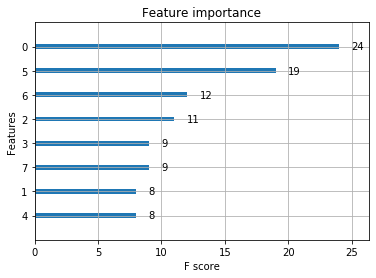

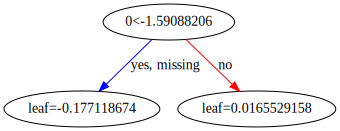

In [70]:
boost = XGBClassifier(max_depth=1, random_state=0)
boost.fit(X_train, y_train)
xgboost = boost.predict(X_test)

# Matrice de confusion : tester les True et False, Positive et Negative :
print("Matrice de confusion (classes prédites vs réalité) :\n", confusion_matrix(y_test, xgboost))
# Evaluation des données prédites par rapport aux données réelles de test :
print("Accuracy score :\n", accuracy_score(y_test, xgboost))

# Visualisation XG Boost
xgb.plot_importance(boost)
plt.show()
# Decision Tree
xgb.to_graphviz(boost, num_trees=40)

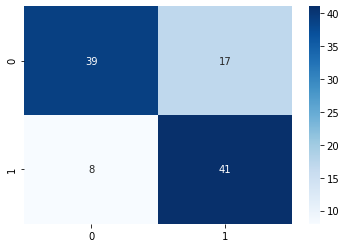

In [71]:
sns.heatmap(confusion_matrix(y_test, xgboost),annot=True,cmap="Blues")

### Visualisation sur 6 composantes 

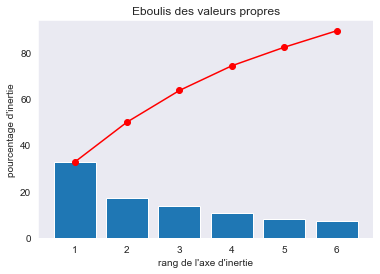

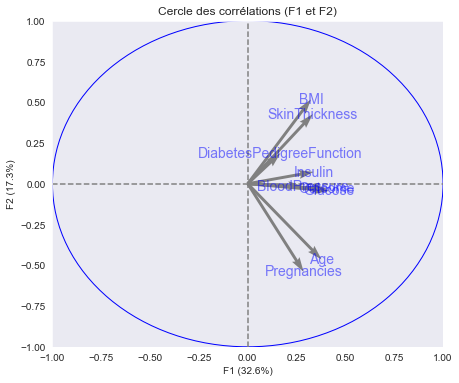

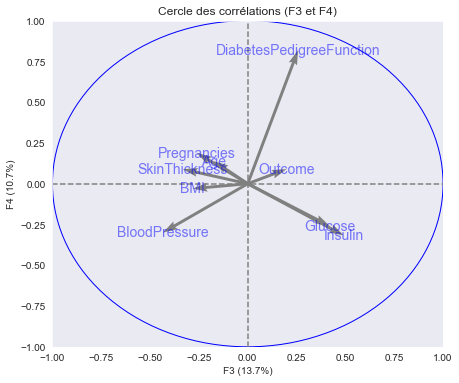

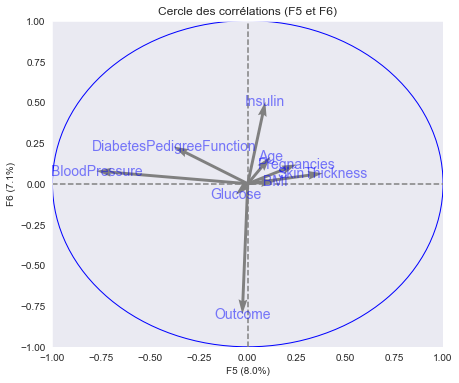

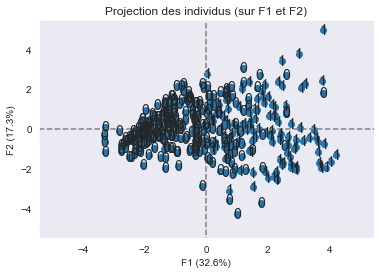

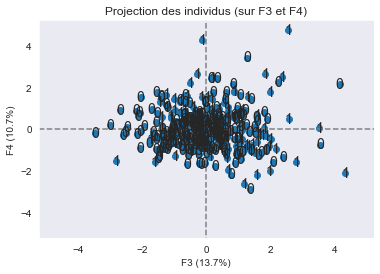

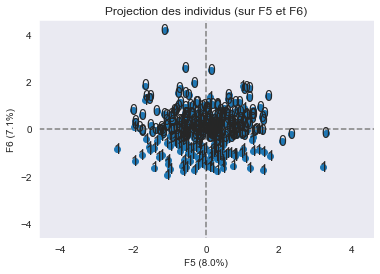

In [136]:
# Choix du nombre de composantes à calculer
n_comp = 6

# Sélection des colonnes à prendre en compte dans l'ACP
data_pca = dataclean[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]

# Préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = dataclean["Outcome"] # ou data.index pour avoir les intitulés
features = dataclean.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
functions.display_scree_plot(pca)

# Cercle des corrélations  
pcs = pca.components_
functions.display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
functions.display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()